In [1]:
# ===================== Basic Libraries =====================
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

# ===================== Visualization =====================
import matplotlib.pyplot as plt
import seaborn as sns

# ===================== Data Preparation =====================
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin

# ===================== Models =====================
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# ===================== Evaluation =====================
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.metrics import ConfusionMatrixDisplay

# ===================== Pipelines =====================
from imblearn.pipeline import Pipeline

# ===================== Utilities =====================
import joblib

In [2]:
aidev = pd.read_csv("ai_dev_productivity.csv")

aidev.head(5)

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
0,5.99,600,1,5.8,2,1,0.71,5.4,1
1,4.72,568,2,6.9,5,3,1.75,4.7,1
2,6.30,560,1,8.9,2,0,2.27,2.2,1
3,8.05,600,7,6.3,9,5,1.40,5.9,0
4,4.53,421,6,6.9,4,0,1.26,6.3,1


In [3]:
aidev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hours_coding      500 non-null    float64
 1   coffee_intake_mg  500 non-null    int64  
 2   distractions      500 non-null    int64  
 3   sleep_hours       500 non-null    float64
 4   commits           500 non-null    int64  
 5   bugs_reported     500 non-null    int64  
 6   ai_usage_hours    500 non-null    float64
 7   cognitive_load    500 non-null    float64
 8   task_success      500 non-null    int64  
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


In [4]:
aidev.describe()

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000
mean,5.015600,463.192000,2.976000,6.975800,4.60800,0.858000,1.510920,4.498200,0.606000
std,1.947253,142.334991,1.678409,1.455965,2.70499,1.102846,1.085557,1.868861,0.489124
min,0.000000,6.000000,0.000000,3.000000,0.00000,0.000000,0.000000,1.000000,0.000000
25%,3.600000,369.500000,2.000000,6.100000,3.00000,0.000000,0.697500,3.175000,0.000000
50%,5.030000,500.500000,3.000000,6.950000,5.00000,0.000000,1.260000,4.400000,1.000000
75%,6.275000,600.000000,4.000000,7.900000,6.00000,2.000000,2.070000,5.800000,1.000000
max,12.000000,600.000000,8.000000,10.000000,13.00000,5.000000,6.360000,10.000000,1.000000


## **Analyzing relationships between data features**

### What is the overall task success rate?

In [5]:
success_rate = aidev["task_success"].mean()
print(f"Overall task success rate: {success_rate:.2%}")

Overall task success rate: 60.60%


### Sleep hours effect on productivity

In [6]:
aidev['sleepLabel'] = pd.cut(x=aidev['sleep_hours'], bins=[0, 6, 8, 10],
                     labels=['<6', '6-8', '8-10'])

aidev.head(5)

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success,sleepLabel
0,5.99,600,1,5.8,2,1,0.71,5.4,1,<6
1,4.72,568,2,6.9,5,3,1.75,4.7,1,6-8
2,6.30,560,1,8.9,2,0,2.27,2.2,1,8-10
3,8.05,600,7,6.3,9,5,1.40,5.9,0,6-8
4,4.53,421,6,6.9,4,0,1.26,6.3,1,6-8


In [7]:
print('Task success rate by sleep category:')
aidev.groupby('sleepLabel')[['task_success','bugs_reported','cognitive_load']].mean()

Task success rate by sleep category:


,task_success,bugs_reported,cognitive_load
sleepLabel,,,
<6,0.459677,1.338710,6.285484
6-8,0.657795,0.870722,4.412928
8-10,0.646018,0.300885,2.735398


In [8]:
bugs_ratio = aidev[aidev['sleep_hours']<6]['bugs_reported'].mean() / aidev[aidev['sleep_hours']>=6]['bugs_reported'].mean()
print(f"effect of sleeping less than 6 hours results in {(bugs_ratio - 1) * 100:.2f}% more bugs")

effect of sleeping less than 6 hours results in 87.48% more bugs


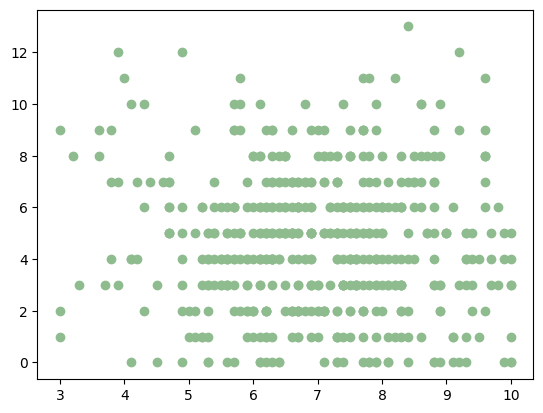

In [9]:
plt.scatter(aidev['sleep_hours'],aidev['commits'], c='darkseagreen')
plt.show()

### **Ai usage effect**

In [10]:
aidev['no_ai_hours'] = aidev['hours_coding']- aidev['ai_usage_hours']
aidev

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success,sleepLabel,no_ai_hours
0,5.99,600,1,5.8,2,1,0.71,5.4,1,<6,5.28
1,4.72,568,2,6.9,5,3,1.75,4.7,1,6-8,2.97
2,6.30,560,1,8.9,2,0,2.27,2.2,1,8-10,4.03
3,8.05,600,7,6.3,9,5,1.40,5.9,0,6-8,6.65
4,4.53,421,6,6.9,4,0,1.26,6.3,1,6-8,3.27
...,...,...,...,...,...,...,...,...,...,...,...
495,6.08,594,1,5.3,3,0,0.91,6.8,1,<6,5.17
496,2.93,382,2,6.7,3,2,1.38,5.9,0,6-8,1.55
497,4.62,494,4,7.5,2,0,0.41,4.5,1,6-8,4.21
498,3.25,296,6,6.9,1,0,1.52,6.3,0,6-8,1.73


In [11]:
aidev['aiUsageLabel'] = pd.cut(x=aidev['ai_usage_hours'], bins=[0, 1, 3, 5, 6.5],
                     labels=['<1', '1-3', '3-5','>5'])

ai_comparsion = aidev.groupby('aiUsageLabel')[['commits','bugs_reported','cognitive_load','no_ai_hours','task_success']].mean()
ai_comparsion

,commits,bugs_reported,cognitive_load,no_ai_hours,task_success
aiUsageLabel,,,,,
<1,3.755208,0.671875,4.319792,3.538021,0.479167
1-3,4.835938,0.968750,4.568750,3.496836,0.667969
3-5,6.636364,1.045455,4.763636,3.513409,0.795455
>5,8.833333,0.833333,5.333333,3.876667,0.833333


In [12]:
commits_diff = (ai_comparsion.loc['1-3','commits'] - ai_comparsion.loc['<1','commits'])/ai_comparsion.loc['<1','commits']
print(f"Moderate usage (1-3) increased commits by {commits_diff * 100:.2f}%")

Moderate usage (1-3) increased commits by 28.78%


In [13]:
Tsuccess_diff = (ai_comparsion.loc['3-5','task_success'] - ai_comparsion.loc['<1','task_success'])/ai_comparsion.loc['<1','task_success']
print(f"Moderate usage (3-5) increased Task success by {Tsuccess_diff * 100:.2f}%")

Moderate usage (3-5) increased Task success by 66.01%


In [14]:
cog_diff = (ai_comparsion.loc['>5','cognitive_load'] - ai_comparsion.loc['<1','cognitive_load'])/ai_comparsion.loc['<1','cognitive_load']
print(f"Exessive usage (>5) increased cognitive load by {cog_diff * 100:.2f}%")

Exessive usage (>5) increased cognitive load by 23.46%


### **Coffee intake effect**

In [15]:
aidev['coffeeLabel'] = pd.cut(x=aidev['coffee_intake_mg'], bins=[0, 300, 500, 600],
                     labels=['<300', '300-500', '>500'])

print(aidev['coffeeLabel'].value_counts())
aidev.head(5)

>500       250
300-500    170
<300        80
Name: coffeeLabel, dtype: int64


,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success,sleepLabel,no_ai_hours,aiUsageLabel,coffeeLabel
0,5.99,600,1,5.8,2,1,0.71,5.4,1,<6,5.28,<1,>500
1,4.72,568,2,6.9,5,3,1.75,4.7,1,6-8,2.97,1-3,>500
2,6.30,560,1,8.9,2,0,2.27,2.2,1,8-10,4.03,1-3,>500
3,8.05,600,7,6.3,9,5,1.40,5.9,0,6-8,6.65,1-3,>500
4,4.53,421,6,6.9,4,0,1.26,6.3,1,6-8,3.27,1-3,300-500


In [16]:
coffee_comparsion = aidev.groupby('coffeeLabel')[['commits','bugs_reported','cognitive_load','task_success']].mean()
coffee_comparsion

,commits,bugs_reported,cognitive_load,task_success
coffeeLabel,,,,
<300,2.075000,0.725000,4.542500,0.000000
300-500,3.976471,0.823529,4.251176,0.488235
>500,5.848000,0.924000,4.652000,0.880000


In [17]:
Tsuccess_diff2 = coffee_comparsion.loc['300-500','task_success']
print(f"Average intake (300-500) increased Task success rate by {Tsuccess_diff2 * 100:.2f}% than low usage (<300)")

Average intake (300-500) increased Task success rate by 48.82% than low usage (<300)


In [18]:
cog_diff2 = (coffee_comparsion.loc['<300','cognitive_load'] - coffee_comparsion.loc['300-500','cognitive_load'])/coffee_comparsion.loc['<300','cognitive_load']
print(f"Average intake (300-500) decreased cognitive load by {cog_diff2 * 100:.2f}% than low usage (<300)")

Average intake (300-500) decreased cognitive load by 6.41% than low usage (<300)


In [19]:
cog_diff3 = (coffee_comparsion.loc['>500','cognitive_load'] - coffee_comparsion.loc['300-500','cognitive_load'])/coffee_comparsion.loc['300-500','cognitive_load']
print(f"Over-Caffeination (>500) increased cognitive load by {cog_diff3 * 100:.2f}% than normal usage (300-500)")

Over-Caffeination (>500) increased cognitive load by 9.43% than normal usage (300-500)


### **Distraction level effect**

### How does task success rate vary by distraction level?

In [20]:
print('Task success rate by distractions:')

aidev.groupby('distractions')['task_success'].mean()

Task success rate by distractions:


distractions
0    0.631579
1    0.753086
2    0.598291
3    0.571429
4    0.592593
5    0.511111
6    0.571429
7    0.562500
8    0.000000
Name: task_success, dtype: float64

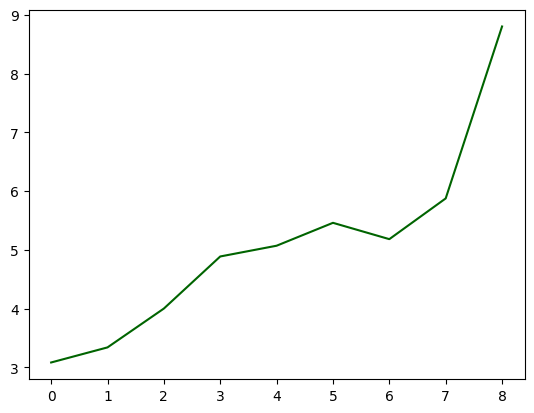

In [21]:
plt.plot(aidev.groupby('distractions')['cognitive_load'].mean(),c="darkgreen")

In [22]:
cog_distract_gp1 = aidev[aidev['distractions']>=3]['cognitive_load']
cog_distract_gp2 = aidev[aidev['distractions']<3]['cognitive_load']

In [23]:
cog_diff4 = (cog_distract_gp1.mean() - cog_distract_gp2.mean())/cog_distract_gp2.mean()
print(f"3+ distractions increased cognitive load by {cog_diff4 * 100:.2f}% ")

3+ distractions increased cognitive load by 39.60% 


In [24]:
com_distract_gp1 = aidev[aidev['distractions']>=2]['commits']
com_distract_gp2 = aidev[aidev['distractions']<2]['commits']

In [25]:
commits_diff2 = (com_distract_gp2.mean() - com_distract_gp1.mean())/com_distract_gp1.mean()
print(f"<2 distractions increased commits by {commits_diff2 * 100:.2f}% ")

<2 distractions increased commits by 6.65% 


## **Cleaning and preprocessing**

In [26]:
aidev.duplicated().sum()

0

In [27]:
aidev.head()

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success,sleepLabel,no_ai_hours,aiUsageLabel,coffeeLabel
0,5.99,600,1,5.8,2,1,0.71,5.4,1,<6,5.28,<1,>500
1,4.72,568,2,6.9,5,3,1.75,4.7,1,6-8,2.97,1-3,>500
2,6.30,560,1,8.9,2,0,2.27,2.2,1,8-10,4.03,1-3,>500
3,8.05,600,7,6.3,9,5,1.40,5.9,0,6-8,6.65,1-3,>500
4,4.53,421,6,6.9,4,0,1.26,6.3,1,6-8,3.27,1-3,300-500


In [28]:
aidev = aidev.drop(["sleepLabel",	"no_ai_hours",	"aiUsageLabel",	"coffeeLabel"], axis=1)

### **Visualizing features distribution**

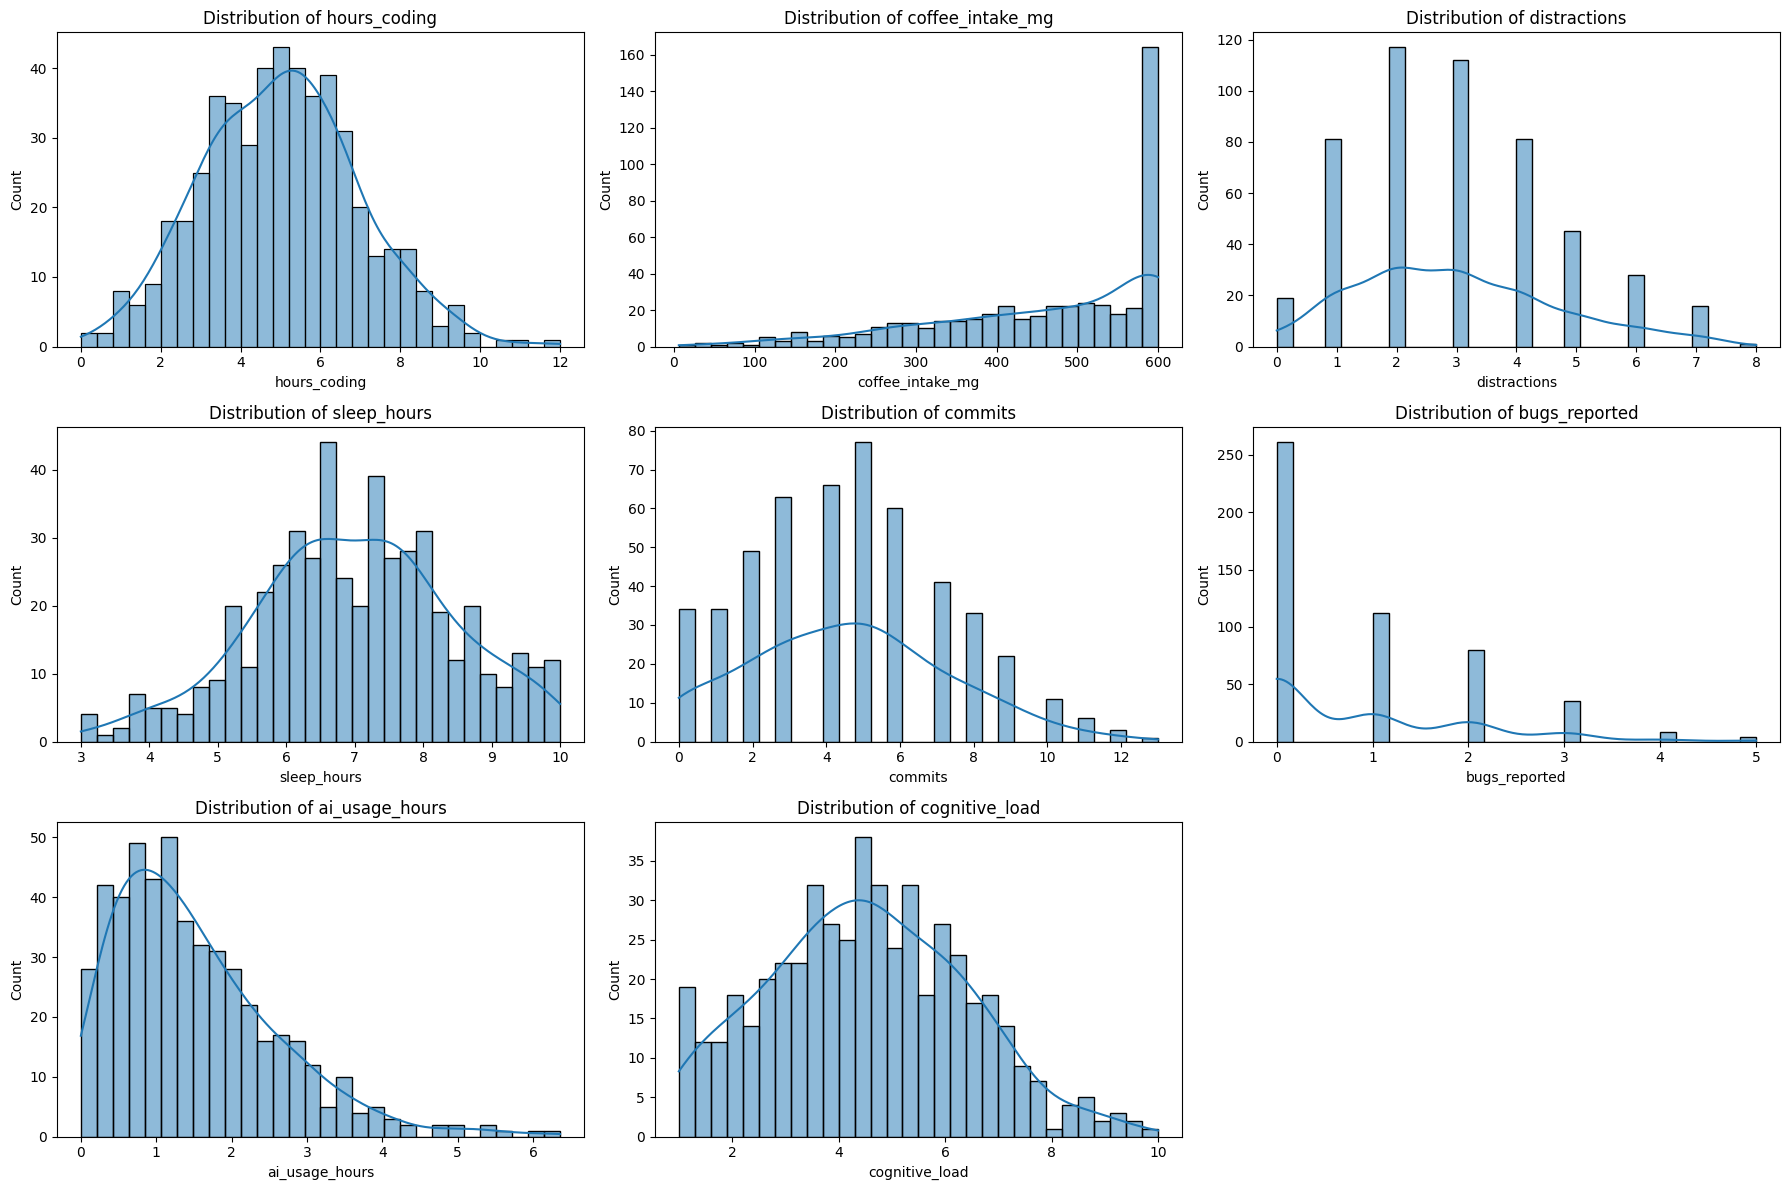

In [29]:
features = ['hours_coding', 'coffee_intake_mg', 'distractions', 'sleep_hours',
            'commits', 'bugs_reported', 'ai_usage_hours', 'cognitive_load']

# Set the layout
plt.figure(figsize=(18, 12))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.histplot(aidev[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.tight_layout()
plt.show()

### **Data splitting**

In [30]:
X = aidev.iloc[:, :-1]   # all columns except last
y = aidev.iloc[:, -1]    # last column as target

In [31]:
# Splitting into 70% training , 15% validation and 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

In [32]:
X_train

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load
107,5.35,473,5,9.1,1,0,1.14,1.5
220,9.63,600,3,8.4,13,0,3.54,5.6
361,8.07,600,3,4.6,7,1,4.92,7.2
438,1.59,172,4,7.3,1,0,0.41,4.3
93,4.34,451,4,6.5,5,3,0.68,5.8
...,...,...,...,...,...,...,...,...
171,3.37,233,3,7.9,6,1,1.06,5.0
432,4.46,374,3,8.8,5,0,2.01,4.6
461,5.07,574,7,8.8,4,0,1.15,5.8
394,7.36,600,0,8.1,6,0,4.15,1.8


### **Dealing with outliers**

In [33]:
def remove_outliers_iqr(X, y, iqr_multiplier=1.5):
    Q1 = np.percentile(X, 25, axis=0)
    Q3 = np.percentile(X, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR
    mask = np.all((X >= lower_bound) & (X <= upper_bound), axis=1)
    return X[mask], y[mask]

X_train_filtered, y_train_filtered = remove_outliers_iqr(X_train, y_train)

num_removed = len(X_train) - len(X_train_filtered)
print(f"Number of values removed: {num_removed}")

X_train, y_train = X_train_filtered, y_train_filtered

Number of values removed: 18


### **Feature engineering**

In [34]:
X_train['coffee_per_hour'] = X_train['coffee_intake_mg'] / (X_train['hours_coding'] + 1)
X_val['coffee_per_hour'] = X_val['coffee_intake_mg'] / (X_val['hours_coding'] + 1)
X_test['coffee_per_hour'] = X_test['coffee_intake_mg'] / (X_test['hours_coding'] + 1)

In [35]:
X_train['squared_ai_usage'] = (X_train['ai_usage_hours'])**2
X_val['squared_ai_usage'] = (X_val['ai_usage_hours'])**2
X_test['squared_ai_usage'] = (X_test['ai_usage_hours'])**2

In [36]:
X_train['log_coffee_intake'] = np.log1p(X_train['coffee_intake_mg'])
X_test['log_coffee_intake'] = np.log1p(X_test['coffee_intake_mg'])
X_val['log_coffee_intake'] = np.log1p(X_val['coffee_intake_mg'])

### **Handling Imbalanced Data**

In [37]:
y_train.value_counts()

1    202
0    130
Name: task_success, dtype: int64

*we can notice the imbalanced nature of dataset*

In [38]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [39]:
y_train.value_counts()

1    202
0    202
Name: task_success, dtype: int64

### **Feature Scaling**

In [40]:
scaler = StandardScaler()
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_val = scaler.transform(X_val)      
X_test = scaler.transform(X_test)    

## **Machine learning model**

In [41]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import joblib

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

#### Finding out the best model

In [42]:
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=7),
    'Naive Bayes': GaussianNB(),
    'SVM (linear)': SVC(kernel='linear')
}

results = {}

cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    mean_score = scores.mean()
    cv_results[name] = mean_score
    print(f"{name} Cross-Validated Accuracy (5-fold): {mean_score:.2f}")

Logistic Regression Cross-Validated Accuracy (5-fold): 0.86
KNN (k=5) Cross-Validated Accuracy (5-fold): 0.90
Naive Bayes Cross-Validated Accuracy (5-fold): 0.86
SVM (linear) Cross-Validated Accuracy (5-fold): 0.86


Obviously, KNN performed the best which will take us to the nexts step which Hyperparameter tuning

#### Hyperparameter tuning

In [43]:
k_values = [1, 3, 5, 7, 9, 11]
weight_options = ['uniform', 'distance']
metrics = ['euclidean', 'manhattan']

best_score = 0
best_params = {}

for k in k_values:
    for w in weight_options:
        for m in metrics:
            model = KNeighborsClassifier(n_neighbors=k, weights=w,metric=m)
            model.fit(X_train, y_train)
            val_preds = model.predict(X_val)
            f1 = f1_score(y_val, val_preds)

            if f1 > best_score:
                best_score = f1
                best_params = {'n_neighbors': k, 'weights': w, 'metric':m}

print(f"\n✅ Best Params on Validation Set: {best_params}, F1_score: {best_score:.2f}")



✅ Best Params on Validation Set: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}, F1_score: 0.93


#### Finally, Evaluating on the test set

In [44]:
best_knn = KNeighborsClassifier(n_neighbors=7, weights='distance',metric='manhattan')

# Train on full training data (train + val)
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.hstack((y_train, y_val))
best_knn.fit(X_train_full, y_train_full)

# Test set
test_preds = best_knn.predict(X_test)
test_acc = f1_score(y_test, test_preds)
print(f"\nTest Accuracy with Tuned KNN: {test_acc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, test_preds))


Test Accuracy with Tuned KNN: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        30
           1       0.88      0.96      0.91        45

    accuracy                           0.89        75
   macro avg       0.90      0.88      0.89        75
weighted avg       0.90      0.89      0.89        75



Scored 91% f1-score which represnts a good perfomance

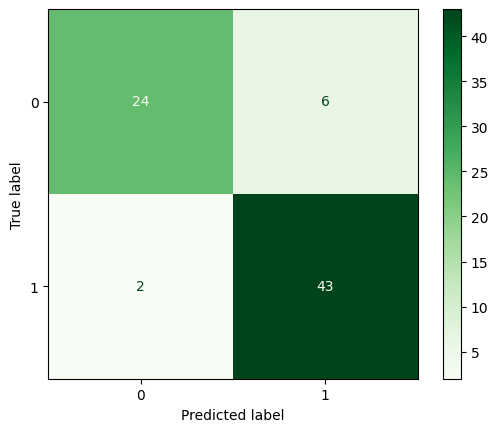

In [45]:
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Greens")

In [46]:
probs = best_knn.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
print(f"AUC: {roc_auc:.2f}")

AUC: 0.97


0.97 ROC-AUC means our model:
- Correctly ranks positive samples above negatives 97% of the time.
- Has strong class separation power, even if thresholds vary.

## **Setting up the pipeline**

In [47]:
# 1. Split into train+val and test (85% / 15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# 2. Split train+val into train (70%) and val (15%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
)

# 3. Combine train + val for full training set
X_train_full = pd.concat([X_train, X_val], ignore_index=True)
y_train_full = pd.concat([y_train, y_val], ignore_index=True)

# 4. Define your IQR outlier removal function
def remove_outliers_iqr(X_array, y_array, iqr_multiplier=1.5):
    Q1 = np.percentile(X_array, 25, axis=0)
    Q3 = np.percentile(X_array, 75, axis=0)
    IQR = Q3 - Q1
    lower = Q1 - iqr_multiplier * IQR
    upper = Q3 + iqr_multiplier * IQR
    mask = np.all((X_array >= lower) & (X_array <= upper), axis=1)
    return X_array[mask], y_array[mask]

# 5. Remove outliers from the full training set
X_np = X_train_full.to_numpy()
y_np = y_train_full.to_numpy()
X_filt, y_filt = remove_outliers_iqr(X_np, y_np, iqr_multiplier=1.5)

# 6. Convert back to DataFrame (so FeatureEngineering can use column names)
X_filt = pd.DataFrame(X_filt, columns=X.columns)
y_filt = pd.Series(y_filt)

# 7. Define your custom feature engineering transformer
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['coffee_per_hour'] = X['coffee_intake_mg'] / (X['hours_coding'] + 1)
        X['squared_ai_usage'] = X['ai_usage_hours'] ** 2
        X['log_coffee_intake'] = np.log1p(X['coffee_intake_mg'])
        return X

# 8. Build the pipeline (no outlier removal step here)
pipeline = Pipeline([
    ('features', FeatureEngineering()),
    ('smote',    SMOTE(random_state=42)),
    ('scaler',   StandardScaler()),
    ('model',    best_knn)
])

# 9. Fit pipeline on the filtered training data
pipeline.fit(X_filt, y_filt)

# 10. Evaluate on the untouched test set
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print("Test Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Test AUC      :", roc_auc_score(y_test, y_prob))

# 11. Save the trained pipeline for deployment
joblib.dump(pipeline, "model_pipeline.pkl")
print("\n✅ Pipeline trained and saved as 'model_pipeline.pkl'")

Test Accuracy : 0.92

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89        30
           1       0.90      0.98      0.94        45

    accuracy                           0.92        75
   macro avg       0.93      0.91      0.91        75
weighted avg       0.92      0.92      0.92        75

Test AUC      : 0.9837037037037036

✅ Pipeline trained and saved as 'model_pipeline.pkl'
